Autor: Norton Martin Reichert Trennepohl 

Nota: o algoritmo aqui mostrado funciona independentemente do número de lâminas ser par ou ímpar.

## Bibliotecas utilizadas:

In [125]:
import numpy as np
import math
import matplotlib.pyplot as plt
# Para mostrar apenas 3 casas decimaisa
np.set_printoptions(precision=3)

## Constantes e dados de entrada:

In [126]:
# Direções: informar aqui a direção de cada lâmina (em graus), de CIMA para BAIXO em relação ao laminado:
#direc_deg = [0,45,0,45,0,45,45,0,45,0,45,0]
direc_deg = [45,0,0,45]

# Conversão para radianos
direc = np.radians(direc_deg)
n = len(direc)

#Vetor de carregamentos (elementos não-nulos estão em unidades de N/mm)
# Informar aqui os esforços, obedecendo a convenção:
#carreg = [[Nx],[Ny],[Nxy],[Mx],[My],[Mxy]]

carreg = [[1000*1000],[200*1000],[0],[0],[0],[0]] #N/m

#Espessura de cada lâmina (esp): informar 
esp = 3E-3 #m
#esp = float(input('Espessura (em m)'))


#Espessura do laminado
h = n*esp #m

# Dados do material: informar aqui:
E11 = 77E9 #Pa
E22 = 75E9 #Pa
nu12 = 0.06
G12 = 6.5E9 #Pa

#Relação entre coeficientes de Poisson
nu21 = (E22*nu12)/E11

# Informações sobre cirtério de falha (todas em MPa)
XT = 1447E6
XC = -1447E6
YT = 51.7E6
YC = -206E6
S12 = 93E6


## Matriz de rigidez reduzida transformada no sistema global de coordenadas:

In [127]:
Q11 = E11/(1-nu12*nu21)
Q22 = E22/(1-nu12*nu21)
Q66 = G12
Q12 = (nu12*E22)/(1-nu12*nu21)
Q21 = Q12

#Q = np.array([[Q11, Q12, 0],[Q21, Q22, 0], [0, 0, Q66]])
Q = np.array([[181.8E9, 2.897E9, 0],[2.897E9, 10.35E9, 0], [0, 0, 7.17E9]])

cos = np.cos(direc)
sin = np.sin(direc)

# Inicialização dos vetores:
T = [[0 for _ in range(1)] for _ in range(n)]
T_inv = [[0 for _ in range(1)] for _ in range(n)]
Q_dash = [[0 for _ in range(1)] for _ in range(n)]
Reuter = [[1,0,0],[0,1,0],[0,0,2]] # Matriz de Reuter

# Cálculo da matriz Q_dash para cada uma das lâminas 
for i in range(n):
    T[i] = np.array([[cos[i]**2, sin[i]**2, 2*sin[i]*cos[i]],[sin[i]**2, cos[i]**2, -2*sin[i]*cos[i]],[-sin[i]*cos[i], sin[i]*cos[i], cos[i]**2-sin[i]**2]])
    T_inv[i] = np.linalg.inv(T[i])
    Q_dash[i] = T_inv[i]@Q@Reuter@T[i]@np.linalg.inv(Reuter)
#   print(Q_dash[i])


## Matriz "ABBD":

In [128]:
# Matriz A: rigidez à tração e compressão
# Inicialização
A_local = [[0 for _ in range(1)] for _ in range(n)]
A_global = 0

for i in range(n):
    A_local[i] = Q_dash[i]*(((((n/2)-(i+1))/n)*-h) - (((n/2 - i)/n)*-h))
    #A_local[i] = Q_dash[i]*(h/n) # retorna os mesmos resultados, significa que está ok
    A_global = A_global + A_local[i]
#print(A_global)
    
# Matriz B: acoplamento entre rigidez no plano e rigidez à flexão
B_local = [[0 for _ in range(1)] for _ in range(n)]
B_global = 0
for i in range(n):
    B_local[i] = 0.5*Q_dash[i]*(((((n/2)-(i+1))/n)*-h)**2 - (((n/2 - i)/n)*-h)**2)
    B_global = B_global + B_local[i]
#print(B_global)

# Matriz D: rigidez à flexão ou torção
D_local = [[0 for _ in range(1)] for _ in range(n)]
D_global = 0
for i in range(n):
    D_local[i] = (1/3)*Q_dash[i]*(((((n/2)-(i+1))/n)*-h)**3 - (((n/2 - i)/n)*-h)**3)
    D_global = D_global + D_local[i]
#print(D_global)

# Combinando as matrizes em uma só   
linha1 = np.vstack((A_global,B_global))
linha2 = np.vstack((B_global,D_global))
ABBD = np.hstack((linha1,linha2))
print("Matriz ABBD:")
print(ABBD)

Matriz ABBD:
[[1.431e+09 2.713e+08 2.572e+08 0.000e+00 0.000e+00 0.000e+00]
 [2.713e+08 4.020e+08 2.572e+08 0.000e+00 0.000e+00 0.000e+00]
 [2.572e+08 2.572e+08 3.226e+08 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 1.041e+04 5.384e+03 5.401e+03]
 [0.000e+00 0.000e+00 0.000e+00 5.384e+03 7.325e+03 5.401e+03]
 [0.000e+00 0.000e+00 0.000e+00 5.401e+03 5.401e+03 5.999e+03]]


Como era esperado, a matriz [B] é nula, já que o laminado é simétrico.

## Deformações no plano médio e curvatura em relação ao sistema global:

In [129]:
# Inicialização do vetor
def_curv = [[0],[0],[0],[0],[0],[0]]

def_curv = np.linalg.inv(ABBD)@carreg

epsilon_0_global = np.vstack((def_curv[0],def_curv[1],def_curv[2]))
K_global = np.vstack((def_curv[3],def_curv[4],def_curv[5]))

print(def_curv)


[[ 0.001]
 [ 0.001]
 [-0.001]
 [ 0.   ]
 [ 0.   ]
 [ 0.   ]]


Percebe-se que os valores de curvatura são muito baixos (podem ser considerados como nulos), o que já era esperado pois não é realizado momento sobre a estrutura. Isso indica que os resultados são condizentes.

## Tensões e deformações em cada lâmina:

In [130]:

# Tensões e deformações em cada lâmina (coordenadas z referenciadas no plano médio de cada lâmina)
sigma_global = [[0 for _ in range(1)] for _ in range(n)]
sigma_local = [[0 for _ in range(1)] for _ in range(n)]
z = [[0 for _ in range(1)] for _ in range(n)]
epsilon_global = [[0 for _ in range(1)] for _ in range(n)]
epsilon_local = [[0 for _ in range(1)] for _ in range(n)]
y = [[0 for _ in range(1)] for _ in range(n)]

for i in range(n):
    z[i] = 0.5*(((((n/2)-(i+1))/n)*-h) + (((n/2 - i)/n)*-h))
    sigma_global[i] = (Q_dash[i]@(epsilon_0_global + (z[i]*K_global)))
    print("==============================")
    print("Resultados lâmina %d:" %(i+1))
    print("Tensão na lâmina no sistema global de coordenadas (MPa): ")
    print(sigma_global[i]*10**-6)
    sigma_local[i] = T[i]@sigma_global[i]
    print("Tensão na lâmina no sistema local de coordenadas (MPa):")
    print(sigma_local[i]*10**-6)
    epsilon_global[i] = epsilon_0_global + z[i]*K_global
    print("Deformação no plano médio da lâmina no sistema global de coordenadas:")
    print(epsilon_global[i])
    epsilon_local[i] = T[i]@epsilon_global[i]
    print("Deformação no plano médio da lâmina no sistema local de coordenadas:")
    print(epsilon_local[i])


    

Resultados lâmina 1:
Tensão na lâmina no sistema global de coordenadas (MPa): 
[[23.569]
 [23.277]
 [ 8.745]]
Tensão na lâmina no sistema local de coordenadas (MPa):
[[32.168]
 [14.678]
 [-0.146]]
Deformação no plano médio da lâmina no sistema global de coordenadas:
[[ 0.001]
 [ 0.001]
 [-0.001]]
Deformação no plano médio da lâmina no sistema local de coordenadas:
[[-4.548e-04]
 [ 1.985e-03]
 [-1.020e-05]]
Resultados lâmina 2:
Tensão na lâmina no sistema global de coordenadas (MPa): 
[[143.097]
 [ 10.057]
 [ -8.745]]
Tensão na lâmina no sistema local de coordenadas (MPa):
[[143.097]
 [ 10.057]
 [ -8.745]]
Deformação no plano médio da lâmina no sistema global de coordenadas:
[[ 0.001]
 [ 0.001]
 [-0.001]]
Deformação no plano médio da lâmina no sistema local de coordenadas:
[[ 0.001]
 [ 0.001]
 [-0.001]]
Resultados lâmina 3:
Tensão na lâmina no sistema global de coordenadas (MPa): 
[[143.097]
 [ 10.057]
 [ -8.745]]
Tensão na lâmina no sistema local de coordenadas (MPa):
[[143.097]
 [ 10.

## Análise de falhas: Máxima tração

In [131]:
CS_1 = [[0 for _ in range(1)] for _ in range(n)]
CS_2 = [[0 for _ in range(1)] for _ in range(n)]
CS_12 = [[0 for _ in range(1)] for _ in range(n)]

#sigma_local_transp = np.transpose(sigma_local)

for i in range(n):
    if sigma_local[i][0,0] > 0:
        CS_1[i] = XT/sigma_local[i][0,0]
    else:
        CS_1[i] = (-XC)/sigma_local[i][0,0]

    if sigma_local[i][1,0] > 0:
        CS_2[i] = YT/sigma_local[i][1,0] 
    else:
        CS_2[i] = (-YC)/sigma_local[i][1,0] 

    if sigma_local[i][2,0] > 0:
        CS_12[i] = S12/abs(sigma_local[i][2,0])
    else:
        CS_12[i] = S12/abs(sigma_local[i][2,0])
   
CS = min([min(CS_1),min(CS_2),min(CS_12)])

# resultados:
print("Margem de segurança pelo critério da máxima tensão: %.3f " %CS)



Margem de segurança pelo critério da máxima tensão: 3.522 


## Tsai-Hill

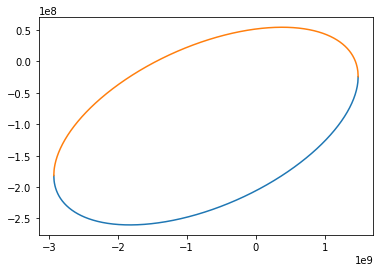

In [132]:
FS_TH = [[0 for _ in range(1)] for _ in range(n)]
MS_TH = [[0 for _ in range(1)] for _ in range(n)]

for i in range(n):
    if sigma_local[i][0,0] > 0 and sigma_local[i][1,0] > 0:
        FS_TH[i] = np.sqrt((sigma_local[i][0,0]/XT)**2 + (sigma_local[i][1,0]/YT)**2 - (sigma_local[i][1,0]*sigma_local[i][0,0]/(XT**2)+(sigma_local[i][2,0]/S12)**2))
        MS_TH[i] = 1/FS_TH[i]
    elif sigma_local[i][0,0] < 0 and sigma_local[i][1,0] > 0:
        FS_TH[i] = np.sqrt((sigma_local[i][0,0]/XC)**2 + (sigma_local[i][1,0]/YT)**2 - (sigma_local[i][1,0]*sigma_local[i][0,0]/(XC**2)+(sigma_local[i][2,0]/S12)**2))
        MS_TH[i] = 1/FS_TH[i] 
    elif sigma_local[i][0,0] < 0 and sigma_local[i][1,0] < 0:
        FS_TH[i] = np.sqrt((sigma_local[i][0,0]/XC)**2 + (sigma_local[i][1,0]/YC)**2 - (sigma_local[i][1,0]*sigma_local[i][0,0]/(XC**2)+(sigma_local[i][2,0]/S12)**2))
        MS_TH[i] = 1/FS_TH[i]
    elif sigma_local[i][0,0] > 0 and sigma_local[i][1,0] < 0:
        FS_TH[i] = np.sqrt((sigma_local[i][0,0]/XT)**2 + (sigma_local[i][1,0]/YC)**2 - (sigma_local[i][1,0]*sigma_local[i][0,0]/(XT**2)+(sigma_local[i][2,0]/S12)**2))
        MS_TH[i] = 1/FS_TH[i]   
    

print("Margem de segurança pelo critério de Tsai-Hill: %.3f " %(min(MS_TH)))


# Superfície de falha:

#mp.splot(f, [0,100],[0,100],points=200)


def grafalha(Xt,Xc,Yt,Yc,S12,sigc,sigt,tau12,vtor):
    for k in range(249):
        vtor[k] = (Yt*np.sqrt(-4*Xt**4*tau12**2+(S12**2*Yt**2-4*S12**2*Xt**2)*sigt[k]**2+4*S12**2*Xt**4)-S12*Yt**2*sigt[k])/(2*S12*Xt**2)
        #print(k)
        vtor[k+250] = (Yt*np.sqrt(-4*Xc**4*tau12**2+(S12**2*Yt**2-4*S12**2*Xc**2)*sigc[k]**2+4*S12**2*Xc**4)+S12*Yt**2*sigc[k])/(2*S12*Xc**2)
        #print(k)
        vtor[k+500] = (Yc*np.sqrt(-4*Xc**4*tau12**2+(S12**2*Yc**2-4*S12**2*Xc**2)*sigc[k]**2+4*S12**2*Xc**4)-S12*Yc**2*sigc[k])/(2*S12*Xc**2)
        #print(k)
        vtor[k+750] = (Yc*np.sqrt(-4*Xt**4*tau12**2+(S12**2*Yc**2-4*S12**2*Xt**2)*sigt[k]**2+4*S12**2*Xt**4)+S12*Yc**2*sigt[k])/(2*S12*Xt**2)
        #print(k)
    
    x_inter1 = -(2*(Yc*Yt*(S12**2*Xc*Xt*Yc**2 + S12**2*Xc*Xt*Yt**2 + S12**2*Xc**2*Yc*Yt + S12**2*Xt**2*Yc*Yt + S12**2*Xc*Xt*Yc*Yt + 3*Xc*Xt*Yc*Yt*tau12**2 - S12**2*Xc*Xt**2*Yc*Yt**2*(1/(Xc*Xt*Yc*Yt))**(1/2) - S12**2*Xc*Xt**2*Yc**2*Yt*(1/(Xc*Xt*Yc*Yt))**(1/2) - S12**2*Xc**2*Xt*Yc*Yt**2*(1/(Xc*Xt*Yc*Yt))**(1/2) - S12**2*Xc**2*Xt*Yc**2*Yt*(1/(Xc*Xt*Yc*Yt))**(1/2)))**(1/2) - 2*S12*Xc*Yc*Yt - 2*S12*Xt*Yc*Yt + S12*Xc*Xt*Yc*Yt**2*(1/(Xc*Xt*Yc*Yt))**(1/2) + S12*Xc*Xt*Yc**2*Yt*(1/(Xc*Xt*Yc*Yt))**(1/2))/(3*S12*Yc*Yt)
    x_inter2 = (2*(Yc*Yt*(S12**2*Xc*Xt*Yc**2 + S12**2*Xc*Xt*Yt**2 + S12**2*Xc**2*Yc*Yt + S12**2*Xt**2*Yc*Yt + S12**2*Xc*Xt*Yc*Yt + 3*Xc*Xt*Yc*Yt*tau12**2 - S12**2*Xc*Xt**2*Yc*Yt**2*(1/(Xc*Xt*Yc*Yt))**(1/2) - S12**2*Xc*Xt**2*Yc**2*Yt*(1/(Xc*Xt*Yc*Yt))**(1/2) - S12**2*Xc**2*Xt*Yc*Yt**2*(1/(Xc*Xt*Yc*Yt))**(1/2) - S12**2*Xc**2*Xt*Yc**2*Yt*(1/(Xc*Xt*Yc*Yt))**(1/2)))**(1/2) + 2*S12*Xc*Yc*Yt + 2*S12*Xt*Yc*Yt - S12*Xc*Xt*Yc*Yt**2*(1/(Xc*Xt*Yc*Yt))**(1/2) - S12*Xc*Xt*Yc**2*Yt*(1/(Xc*Xt*Yc*Yt))**(1/2))/(3*S12*Yc*Yt)
    sig1 = np.linspace(x_inter1,x_inter2, 1000)
    sig2 = np.linspace(0, 0, 1000)
    sig3 = np.linspace(0, 0, 1000)
    for k in range(1000):
        sig2[k] = (np.sqrt(4*Xc**2*Xt**2*Yc*Yt*tau12**2-3*S12**2*Xc*Xt*Yc*Yt*sig1[k]**2+(((4*S12**2*Xc*Xt**2+4*S12**2*Xc**2*Xt)*Yc-2*S12**2*Xc**2*Xt**2*Yc**2*np.sqrt(1/(Xc*Xt*Yc*Yt)))*Yt-2*S12**2*Xc**2*Xt**2*Yc*np.sqrt(1/(Xc*Xt*Yc*Yt))*Yt**2)*sig1[k]+S12**2*Xc**2*Xt**2*Yt**2-2*S12**2*Xc**2*Xt**2*Yc*Yt+S12**2*Xc**2*Xt**2*Yc**2)-S12*Xc*Xt*Yc*np.sqrt(1/(Xc*Xt*Yc*Yt))*Yt*sig1[k]+S12*Xc*Xt*Yt+S12*Xc*Xt*Yc)/(2*S12*Xc*Xt)
        sig3[k] = -(np.sqrt(4*Xc**2*Xt**2*Yc*Yt*tau12**2-3*S12**2*Xc*Xt*Yc*Yt*sig1[k]**2+(((4*S12**2*Xc*Xt**2+4*S12**2*Xc**2*Xt)*Yc-2*S12**2*Xc**2*Xt**2*Yc**2*np.sqrt(1/(Xc*Xt*Yc*Yt)))*Yt-2*S12**2*Xc**2*Xt**2*Yc*np.sqrt(1/(Xc*Xt*Yc*Yt))*Yt**2)*sig1[k]+S12**2*Xc**2*Xt**2*Yt**2-2*S12**2*Xc**2*Xt**2*Yc*Yt+S12**2*Xc**2*Xt**2*Yc**2)+S12*Xc*Xt*Yc*np.sqrt(1/(Xc*Xt*Yc*Yt))*Yt*sig1[k]-S12*Xc*Xt*Yt-S12*Xc*Xt*Yc)/(2*S12*Xc*Xt)
    #Plotando
    #    d=get('current_figure')
    #plt.plot([Xt,Xc,Xc,Xt,Xt],[Yt,Yt,Yc,Yc,Yt]) #Máxima tensão
#     e = gce()
#     e.children.thickness=3
#    plt.plot(sigt,vtor[0:249]) #Tsai-Hill 1º Quadrante
#     e = gce()
#     e.children.thickness = 3
#    plt.plot(sigc,vtor[250:499]) #Tsai-Hill 2º Quadrante
#     e = gce()
#     e.children.thickness = 3
#    plt.plot(sigc,vtor[500:749]) #Tsai-Hill 3º Quadrante
#     e = gce()
#     e.children.thickness = 3
#    plt.plot(sigt,vtor[750:999]) #Tsai-Hill 4º Quadrante
#     e = gce()
#     e.children.thickness = 3
    plt.plot(sig1,sig2) #Tsai-Wu Positivo
#     e = gce()
#     e.children.thickness = 3
    plt.plot(sig1,sig3) #Tsai-Wu Negativo
#     e = gce()
#     e.children(1).thickness=3
#     plot(tens_l(1,:),tens_l(2,:),'ok')//Tensões locais
#     e = gce()
#     e.children.mark_style = 0
#     title('Análise de Falha','fontsize',2)
#     xlabel("${\sigma_1}\ [\,\text{Pa}\,]$",'fontsize',2)
#     ylabel("${\sigma_2}\ [\,\text{Pa}\,]$",'fontsize',2)



#Propriedades
Xt = XT
Xc = XC
Yt = YT
Yc = YC


#Tensão genérica
sigc = np.linspace(Xc, 0, 249)
sigt = np.linspace(0, Xt, 249)
tau12 = 0
vtor = np.linspace(0, 0, 1000)

k=0
# print(sigc)
# print(sigt)
# print(vtor)

#print(vtor)
fig0 = grafalha(Xt,Xc,Yt,Yc,S12,sigc,sigt,tau12,vtor)




## Tsai-Wu

In [133]:
import math
F1 = 1/XT + 1/XC
F2 = 1/YT + 1/YC
F11 = -1/(XT*XC)
F22 = -1/(YT*YC)
F66 = (1/S12)**2
F12 = -0.5*np.sqrt(F11*F22)

A = [[0 for _ in range(1)] for _ in range(n)]
B = [[0 for _ in range(1)] for _ in range(n)]
Sf_pos = [[0 for _ in range(1)] for _ in range(n)]
Sf_neg = [[0 for _ in range(1)] for _ in range(n)]
Sf = [[0 for _ in range(1)] for _ in range(n)]

for i in range(n):
    A[i] = F11*sigma_local[i][0,0]**2 + F22*sigma_local[i][1,0]**2 + F66*sigma_local[i][2,0]**2 + 2*F12*sigma_local[i][0,0]*sigma_local[i][1,0]
    B[i] = F1*sigma_local[i][0,0] + F2*sigma_local[i][1,0]
    Sf_pos[i] = (-B[i] + np.sqrt(B[i]**2 + 4*A[i]))/(2*A[i])
    Sf_neg[i] = abs((-B[i] - np.sqrt(B[i]**2 + 4*A[i]))/(2*A[i]))

    Sf[i] = min(Sf_pos[i],Sf_neg[i])

print(Sf)

[3.6201394549774983, 4.4036430064350665, 4.4036430064350665, 3.6201394549774983]
